In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [177]:
titanic_data = pd.read_csv('train.csv', index_col='PassengerId')

# Context

Рассмотрим первые пару записей датасета:

In [178]:
titanic_data.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
99995,1,2,"Bell, Adele",female,62.0,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.0,0,0,13273,11.15,NaN,S
99997,0,3,"Childress, Charles",male,37.0,0,0,NaN,9.95,NaN,S
99998,0,3,"Caughlin, Thomas",male,51.0,0,1,458654,30.92,NaN,S
99999,0,3,"Enciso, Tyler",male,55.0,0,0,458074,13.96,NaN,S


In [179]:
titanic_data.shape

(100000, 11)

In [180]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


# Data Quality Assesment

In [351]:
titanic_data.duplicated().any()

False

Дупликатов в датасете нет

In [181]:
titanic_data.isnull().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age          3292
SibSp           0
Parch           0
Ticket       4623
Fare          134
Cabin       67866
Embarked      250
dtype: int64

Мы видим, что есть пропущенные значения в колонках "Age", "Ticket", "Fare", "Embarked". В колонке "Cabin" отсутствует более двух третих значений, поэтому пока непонятно, сможем ли мы в принципе использовать этот признак для дальнейшнего анализа.

### Age

Рассмотрим колонку "Age" и подумаем, каким образом можно заполнить пропущенные значения.

In [182]:
titanic_data['Age'].mean()

38.35547214294576

Средний возраст пассажиров Титаника 38.35 лет. Можно заменить пропущенные значения средним возрастом, но можно рассмотреть и чуть более сложную замену. Посмотрим на средний возраст по классам пассажиров:

In [183]:
mean_age_per_class = titanic_data.groupby(['Pclass'])['Age'].mean()
mean_age_per_class

Pclass
1    44.774464
2    38.631237
3    33.407362
Name: Age, dtype: float64

Мы видим, что чем выше класс пассажира, тем он старше (что, в принципе, логично). Если на место пропущенного возраста вставить средний возраст пассажиров соответсвующего класса, замена получится все-таки чуть более изящной, хоть и далекой от идеала.

In [184]:
titanic_data['Pclass'].unique()

array([1, 3, 2], dtype=int64)

In [185]:
for Pclass in titanic_data['Pclass'].unique():
    titanic_data.loc[(titanic_data['Age'].isna()) & (titanic_data['Pclass'] == Pclass),'Age'] = mean_age_per_class[Pclass]

### Ticket

In [186]:
titanic_data['Ticket'].value_counts()

A/5            602
C.A.           177
SC/PARIS       145
SOTON/O.Q.      80
SC              57
              ... 
186702           1
419665           1
371545           1
193193           1
221532           1
Name: Ticket, Length: 75331, dtype: int64

Мы видим, что номера билетов не только не уникальные, но и не следуют какой-либо схеме. Есть как номера из букв (SC/PARIS) и цифр (221532), так и из их комбинаций (А/5).
Здесь сложно увидеть какую-то логику, поэтому использование этого признака для анализа остается под сомнением.

### Embarked

Посмотрим, откуда чаще всего отправлялись пассажиры.

In [187]:
titanic_data.groupby(['Pclass','Embarked']).count()

Survived   Name    Sex    Age  SibSp  Parch  Ticket   Fare  \
Pclass Embarked                                                               
1      C            11843  11843  11843  11843  11843  11843   11836  11825   
       Q             3751   3751   3751   3751   3751   3751    3750   3746   
       S            14635  14635  14635  14635  14635  14635   14616  14618   
2      C             6156   6156   6156   6156   6156   6156    6093   6146   
       Q              844    844    844    844    844    844     837    841   
       S            21609  21609  21609  21609  21609  21609   20856  21581   
3      C             4188   4188   4188   4188   4188   4188    4020   4183   
       Q              829    829    829    829    829    829     782    829   
       S            35895  35895  35895  35895  35895  35895   32346  35848   

                 Cabin  
Pclass Embarked         
1      C         11039  
       Q          3622  
       S         11726  
2      C          1402  
       Q           267  
       S          1846  
3      C           538  
       Q           133  
       S          1473

Мы видим, что большинство пассажиров, независимо от класса, садились на корабль из порта "S". Так как пропущенных значений в колонке "Embarked" не так много, можно спокойно заменить их на "S".

In [188]:
titanic_data.loc[titanic_data['Embarked'].isna(),'Embarked'] = 'S'

### Cabin

Известных номеров кают не так много, но в них хранится такая информация, как этаж и борт. Можно попытаться её извлечь и на этапе анализа посмjтреть, какова связь между этажом и бортом, где располагалась каюта, и выживаемостью пассажира. 

In [189]:
titanic_data['Deck'] = np.nan
titanic_data.loc[titanic_data['Cabin'].notna(),'Deck'] = titanic_data.loc[titanic_data['Cabin'].notna(),'Cabin'].apply(lambda x : str(x)[0]) 
titanic_data['Deck'].value_counts()

C    11825
B     7439
A     6307
D     3637
E     1749
F      663
G      482
T       32
Name: Deck, dtype: int64

In [190]:
titanic_data['Board'] = np.nan
titanic_data.loc[titanic_data['Cabin'].notna(),'Board'] = titanic_data.loc[titanic_data['Cabin'].notna(),'Cabin'].apply(lambda x : int(str(x)[-1]) % 2 == 1) 
titanic_data['Board'].value_counts()

True     16123
False    16011
Name: Board, dtype: int64

In [191]:
titanic_data.isnull().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket       4623
Fare          134
Cabin       67866
Embarked        0
Deck        67866
Board       67866
dtype: int64

### Fare

Выдвинем предположение, что цену билета для каждого пассажира, у которого этот признак пропущен, можно заменить средней ценой билета пассажиров соответсвующего класса.

In [192]:
titanic_data.groupby(['Pclass']).agg({'Fare' : ['min' ,'max', 'mean']})

Fare                   
         min     max       mean
Pclass                         
1       3.38  744.66  92.653113
2       1.72  613.43  25.756003
3       0.68  640.79  20.618226

Мы видим, что максимальные и минимальные значения у всех трех классов отличаются не так значительно, как можно было бы предположить. Исследуем с помощью графиков boxplot распределения цен на билеты между разными классами.

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

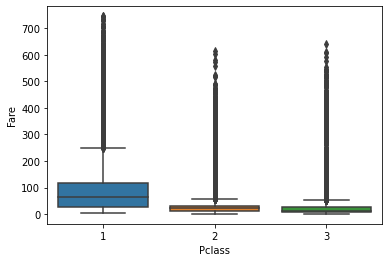

In [193]:
sns.boxplot(x='Pclass', y='Fare', data=titanic_data)

Невооруженным глазом видно огромное количество выбросов, которое, ествественно повлияло на среднюю цену билета. Тогда можно предположить, что корректнее заменить пропущенные значения цен билетов не средним, а модой или медианой.

In [194]:
titanic_data.groupby(['Pclass']).agg({'Fare' : [np.median, pd.Series.mode]})

Fare       
       median   mode
Pclass              
1       63.58  28.88
2       22.72   9.57
3       10.96   8.30

На мой взгляд, медиана позволит более точно заполнить пропущенные значение цен на билеты.

In [195]:
medians = titanic_data.groupby(['Pclass'])['Fare'].median()
medians

Pclass
1    63.58
2    22.72
3    10.96
Name: Fare, dtype: float64

In [196]:
for Pclass in titanic_data['Pclass'].unique():
    titanic_data.loc[(titanic_data['Fare'].isna()) & (titanic_data['Pclass'] == Pclass),'Fare'] = medians[Pclass]

### Итоги

In [197]:
titanic_data.isnull().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket       4623
Fare            0
Cabin       67866
Embarked        0
Deck        67866
Board       67866
dtype: int64

Были заменены все пропущенные значения празнаков "Age", "Fare", "Embarked", также были сгенерированы два новых признака "Board" и "Deck".

# Data Exploration

## Одномерный анализ

Рассмотрим каждый признак по отдельности

### Survived

Выжили 42.774% пассажиров.


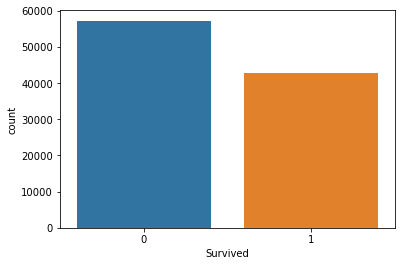

In [198]:
sns.countplot(x='Survived',data=titanic_data)
print("Выжили {}% пассажиров.".format(titanic_data[titanic_data['Survived'] == 1].shape[0] / titanic_data.shape[0]*100))

### Pclass

Класс обслуживания пассажиров (где 1-ый класс - наивысший)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

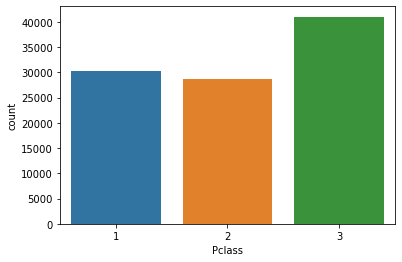

In [199]:
sns.countplot(x='Pclass',data=titanic_data)

Мы видим, что представителей третьего (самого низкого) класса обслуживания больше всего. Запомним этот факт для дальнейшего анализа.

### Name

В оригинальном датасете Титаника в имена включены такие обращения, как мистер, мисс и т.д. Из них можно было делать некие выводы о статусе или возрасте пассажира. В данном же датасете такие обращения опущены:

In [200]:
titanic_data[titanic_data['Name'].str.find('Miss ') != -1].count().sum() + \
titanic_data[titanic_data['Name'].str.find('Mr ') != -1].count().sum() + \
titanic_data[titanic_data['Name'].str.find('Mrs ') != -1].count().sum() + \
titanic_data[titanic_data['Name'].str.find('Ms ') != -1].count().sum() + \
titanic_data[titanic_data['Name'].str.find('Don ') != -1].count().sum()

0

Ни одного пассажира с обращениями Мисс, Миссис и т.д. среди наших данных.

### Sex

Пол пассажира

<AxesSubplot:xlabel='Sex', ylabel='count'>

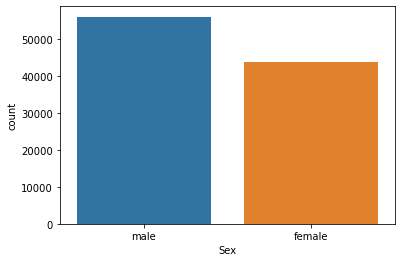

In [201]:
sns.countplot(x='Sex',data=titanic_data,)

In [202]:
fem_percent = titanic_data[titanic_data['Sex'] == 'female'].shape[0] / titanic_data.shape[0]*100
print("На корабле было %.2f%% женщин и %.2f%% мужчин."%(fem_percent, 100 - fem_percent))

На корабле было 43.89% женщин и 56.11% мужчин.


### Age

<AxesSubplot:xlabel='Age', ylabel='Count'>

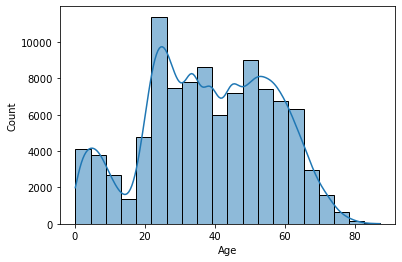

In [203]:
sns.histplot(data=titanic_data, x = 'Age', bins = 20, kde=True)

Мы видим, что основную популяцию пассажиров корабля составляли молодые люди около 20 лет, также взрослые от 30 до 60. Можно также отметить достаточно большое количество детей до 10 лет.

In [204]:
titanic_data['Age'].describe()

count    100000.000000
mean         38.351454
std          18.029996
min           0.080000
25%          25.000000
50%          38.631237
75%          53.000000
max          87.000000
Name: Age, dtype: float64

Самому маленькому пассажиру было 0.08 года - это примерно 1 месяц. Самому пожилому - 87 лет. Средний возраст пассажиров - 38.35 лет, медиана - 38.6.

### SibSp

Общее количество братьев, сестер и супруг(а) для пассажира

<AxesSubplot:ylabel='Frequency'>

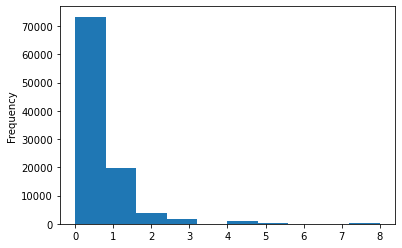

In [205]:
titanic_data['SibSp'].plot(kind='hist')

Мы видим, что большинство пассажиров путешествовали без братьев, сестер и супруг(ов), но есть были и пассажиры, путешествующие в компании еще 8 человек

### Parch

Общее количество родителей + детей пассажира

<AxesSubplot:ylabel='Frequency'>

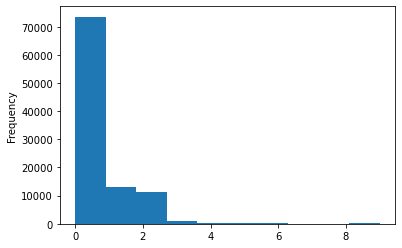

In [206]:
titanic_data['Parch'].plot(kind='hist')

Большинство пассажиров путешествовали без родителей и детей (напомним, что большую часть пассажиров составляли молодые люди около 20 лет, которые уже достаточно самостоятельны, чтобы путешествовать без родителей, но еще не завели детей, а также взрослые люди 40-60 лет, дети которых уже выросли и их необязательно брать с собой). 

### Parch + SibSP

Суммируем количество членов семьи для каждого пассажира в один признак и проанализируем его:

(0.0, 16.0)

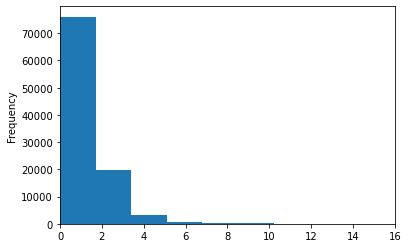

In [234]:
titanic_data['FemMem'] = titanic_data['SibSp'] + titanic_data['Parch']
titanic_data['FemMem'].plot(kind='hist').set_xlim(0,16)

Данный график подтверждает, что большинство пассажиров путешествовали без членов семьи

### Ticket

Этот признак мы в анализе опустим, т.к. на мой взгляд, он не имеет связи с иными празнаками.

### Fare

<AxesSubplot:xlabel='Fare', ylabel='Count'>

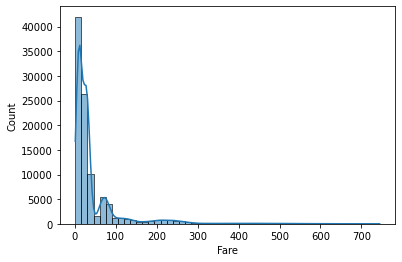

In [207]:
sns.histplot(data=titanic_data, x = 'Fare',bins=50, kde=True)

Мы видим, что у распределения цен на билеты очень длинный правый хвост - много дорогих билетов от 300 до 700. Большинство же пассажиров заплатили сумму от 0 до 100 денежных единиц.

In [208]:
titanic_data['Fare'].describe()

count    100000.000000
mean         43.911139
std          69.548710
min           0.680000
25%          10.040000
50%          24.450000
75%          33.500000
max         744.660000
Name: Fare, dtype: float64

Из приведенных выше статистик видим, что минимальная и максимальная цены билетов - 0.68 и 744.66, соответственно. Средняя цена - 43.91, медиана - 24.45. Медиана так отличается от среднего как раз из-за выбросов в распределении. 

### Cabin

Вместо эого признака рассмотрим два сгенерированных - "Deck" и "Board", палубы и борты, соответсвенно.

<AxesSubplot:xlabel='Deck', ylabel='count'>

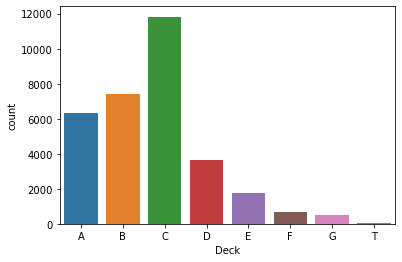

In [218]:
titanic_data.loc[titanic_data['Deck'] == 'n','Deck'] = np.nan
sns.countplot(x='Deck',data=titanic_data.sort_values(['Deck']))

Больше всего пассажиров было на палубе C - примерно посередине корабля. Есть также некое значение Т - в плане корабля такой палубы не указано.

<AxesSubplot:xlabel='Board', ylabel='count'>

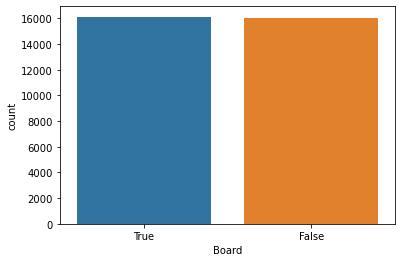

In [220]:
sns.countplot(x='Board',data=titanic_data)

На левом и правом борту пассажиров было примерно поровну.

### Embarked

<AxesSubplot:xlabel='Embarked', ylabel='count'>

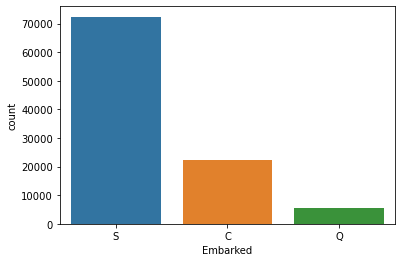

In [221]:
sns.countplot(x='Embarked',data=titanic_data)

Мы видим, что больше всего пассажиров отправлялись из Southampton.

# Двумерный анализ

В этом разделе мы исследуем взаимосвязи признаков попарно.
В первую очередь нас, конечно, интересует связь признаков с нашим таргетом - "Survived".

### Pclass - Survived

In [225]:
titanic_data.groupby(['Pclass','Survived'])['Survived'].count()

Pclass  Survived
1       0           12739
        1           17576
2       0           13622
        1           15057
3       0           30865
        1           10141
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Pclass', ylabel='count'>

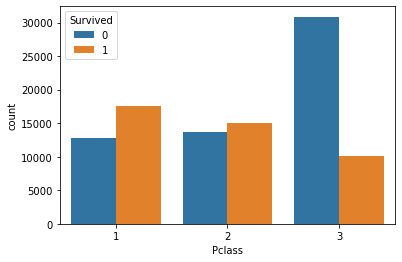

In [224]:
sb.countplot(x='Pclass',hue='Survived',data=titanic_data,)

Мы видим, что более половины представителей первого класса выжили, во втором классе выживших и погибших примерно поровну, в третьем же классе больше пассажиров погибло, чем выжило.
Видимо, класс пассажира имел значение при спасении.

### Sex - Survived

<AxesSubplot:xlabel='Sex', ylabel='count'>

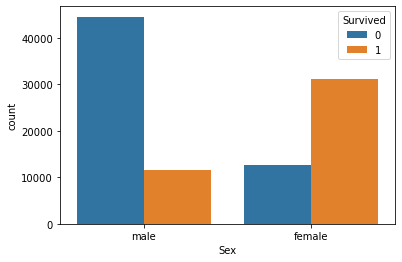

In [226]:
sb.countplot(x='Sex',hue='Survived',data=titanic_data,)

Среди мужчин большая часть пассажиров погибла, среди женщин большая часть пассажирок выжила.
Таким образом, пол пассажира также имел значение при спасении.

### Age - Survived

<AxesSubplot:xlabel='Age', ylabel='Count'>

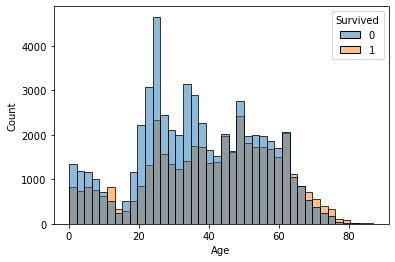

In [231]:
sns.histplot(x='Age', hue='Survived', bins = 40, data=titanic_data)

<AxesSubplot:xlabel='Survived', ylabel='Age'>

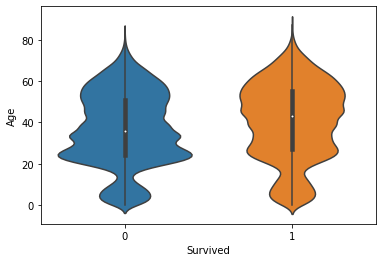

In [243]:
sns.violinplot(x='Survived', y='Age', data=titanic_data)

Мы видим, что среди детей в возрасте до 15-20 лет больше пассажиров погибло, чем выжило. Наибольшая разница между долей погибших и выживших среди молодых пассажиров возрастом 20-40 лет. Среди пассажиров возрастом около 65 и выше больше людей выжило.
Таким образом, возраст тоже играл значение при спасение. Видно, что особое внимание уделялось пожилым людям.

### SibSp - Survived

<AxesSubplot:xlabel='SibSp', ylabel='count'>

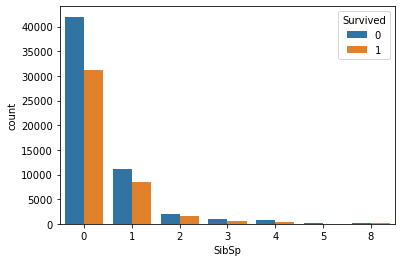

In [237]:
sns.countplot(x='SibSp', hue='Survived', data=titanic_data)

Мы видим, что вне зависимости от количества братьев, сестры и супруг(ов) доля выживших и погибших пассажиров примерно одинакова

### Parch - Survived

<AxesSubplot:xlabel='Parch', ylabel='count'>

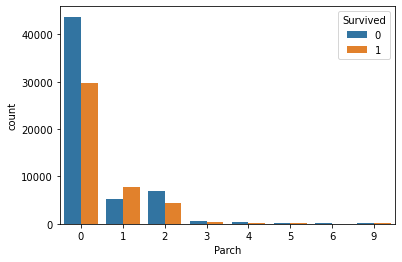

In [238]:
sns.countplot(x='Parch', hue='Survived', data=titanic_data)

Здесь мы так же видим, что доли выживших и погибших примерно одинаковы. Однако при значении Parch = 1 видим, что выживших больше. Возможно, этим одним человеком был родитель, спасающий своего ребенка, или ребенок, спасающий пожилого родителя.

### FemMem - Survived

<AxesSubplot:xlabel='FemMem', ylabel='count'>

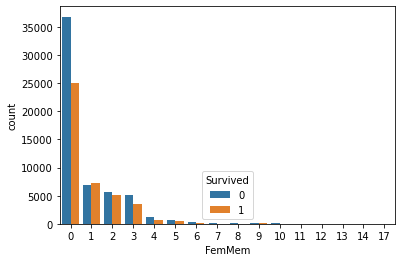

In [239]:
sns.countplot(x='FemMem', hue='Survived', data=titanic_data)

Здесь мы видим, что шансы выжить у одиночек были значительно меньше, чем у людей, которые путешествовали с 1-2 членами семьи.

### Fare - Survived

<AxesSubplot:xlabel='Fare', ylabel='Count'>

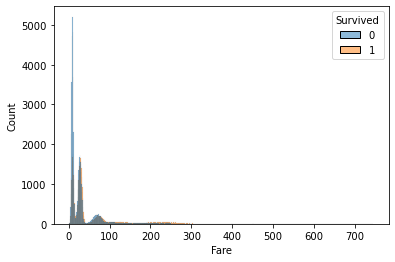

In [256]:
IQR = titanic_data['Fare'].quantile(0.75) - titanic_data['Fare'].quantile(0.25)
sns.histplot(x='Fare',hue='Survived', data=titanic_data)

По этой гистограмме не очень понятно зависимость выживаемости пассажира от цены билета.

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

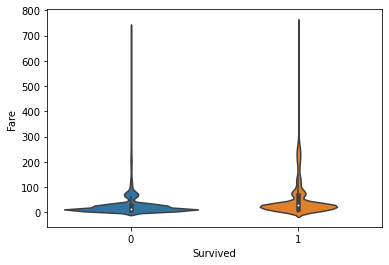

In [290]:
sns.violinplot(y='Fare',x='Survived', data=titanic_data)

Из двух графиков понятно, что пассажиры, заплатившие небольшую сумму за билет, скорее погибали, чем выживали. Что касается пассажиров, отдавших за билет более 100, они с большей вероятностью выживали.
Попробуем исследовать это чуть глубже, разделив пассажиров на несколько категорий в зависимости от стоимости билета.

In [320]:
titanic_data['FareCategory'] = np.nan
for quantile in range(10):
    titanic_data.loc[titanic_data['Fare'] >= titanic_data['Fare'].quantile(quantile/10),'FareCategory'] = quantile + 1
titanic_data['FareCategory'] = titanic_data['FareCategory'].astype(int)

Здесь мы подсчитали десять квантилей (10%-ный, 20%-ный и т.д.).
Если цена билета попадала между нулевым и десятипроцентным квантилем, то значение 'FareCategory' = 1, если между пятидесятипроцентным и шестидесятипроцентным, то 'FareCategory' = 6 и т.д.

Квантиль 60% - 27.84
Квантиль 70% - 31.07
Квантиль 80% - 60.19
Квантиль 90% - 95.77


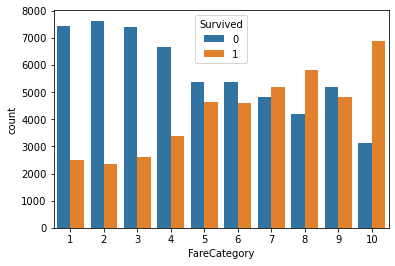

In [323]:
sns.countplot(x='FareCategory', hue='Survived', data=titanic_data)

print("Квантиль 60% - {}\nКвантиль 70% - {}\nКвантиль 80% - {}\nКвантиль 90% - {}".format(titanic_data['Fare'].quantile(0.6),titanic_data['Fare'].quantile(0.7),titanic_data['Fare'].quantile(0.8),titanic_data['Fare'].quantile(0.9)))

А вот это очень интересный результат. Мы видим, что вплоть до 60%-ного квантиля (т.е. когда билеты стоило меньше 27.84) доля погибших превышала долю выживших. После шестидесятипроцентного квантиля пассажиры с большей вероятностью выживали (билеты стоили 31.07 и выше).
Между восьмым и девятым квантилем эта закономерность нарушается (стоимость билетов между 60.19 и 95.77) и больше пассажиров погибло, нежели выжило.
Повторим вычисления с другим количеством квантилей:

Квантиль №9 60% - 27.84
Квантиль №10 66.7% - 29.889999999999855
Квантиль №12 80% - 60.19
Квантиль №13 86.7% - 78.13


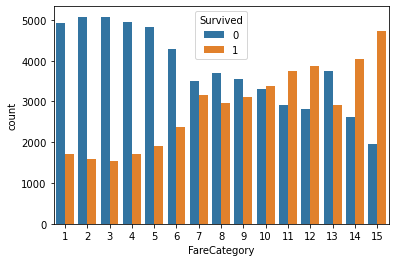

In [325]:
for quantile in range(15):
    titanic_data.loc[titanic_data['Fare'] >= titanic_data['Fare'].quantile(quantile/15),'FareCategory'] = quantile + 1
titanic_data['FareCategory'] = titanic_data['FareCategory'].astype(int)

sns.countplot(x='FareCategory', hue='Survived', data=titanic_data)
print("Квантиль №9 60% - {}\nКвантиль №10 66.7% - {}\nКвантиль №12 80% - {}\nКвантиль №13 86.7% - {}".format(titanic_data['Fare'].quantile(0.6),titanic_data['Fare'].quantile(10/15),titanic_data['Fare'].quantile(0.8),titanic_data['Fare'].quantile(13/15)))

Мы видим, что вплоть до 9-го квантиля (т.е. когда билеты стоило меньше 27.84) доля погибших превышала долю выживших. После 10-го квантиля пассажиры с большей вероятностью выживали (билеты стоили 29.89 и выше).
Между двенадцатым и тринадцатым квантилем эта закономерность нарушается (стоимость билетов между 60.19 и 78.13) и больше пассажиров погибло, нежели выжило.

Теперь мы удостоверились, что нарушение закономерности - это не случайный результат разбиения на 10 квантилей, а в этом промежутке и в самом деле нарушается закономерность.

### Cabin - Survived

Проверим, влиял ли сам факт наличия номера каюты на выживаемость.

<AxesSubplot:xlabel='has_cabin', ylabel='count'>

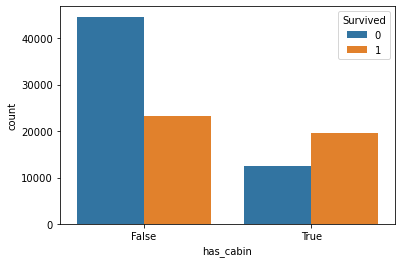

In [327]:
titanic_data['has_cabin'] = titanic_data['Cabin'].notna()
sns.countplot(x='has_cabin', hue='Survived', data=titanic_data)

Интересное наблюдение - среди пассажиров, чей номер каюты известен, больше выжило, нежели погибло.

Теперь рассмотрим связь с признаками, полученными из номера каюты.

### Deck - Survived

<AxesSubplot:xlabel='Deck', ylabel='count'>

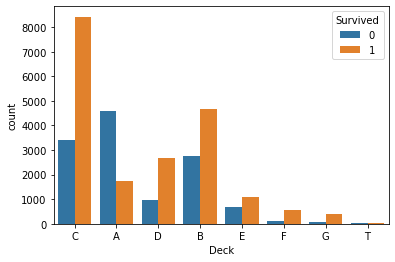

In [328]:
sns.countplot(x='Deck', hue='Survived', data=titanic_data)

Среди тех, кто номер каюты все-таки имеет, почти на всех палубах больше пассажиров выжило, чем погибло (что соответсвует предыдущему графику).
Можно заметить, что только на палубе А - самой высшей - доля погибших больше.

<AxesSubplot:xlabel='Board', ylabel='count'>

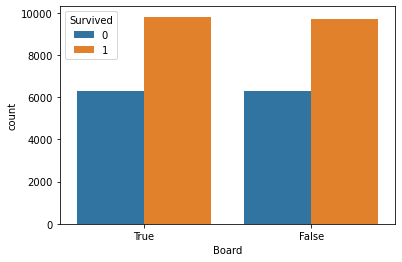

In [329]:
sns.countplot(x='Board', hue='Survived', data=titanic_data)

Не наблюдается зависимость между левым и правым бортом каюты и выживаемостью пассажира.

#### Важное примечание по поводу признака Cabin

Не стоит забывать, что более двух третей значений этого признака отсутсвует, и неясно, можно ли делать какие-либо достоверные выводы, основываясь на значении признака Cabin и сгенерированных из него Deck и Board.

### Embarked - Survived

<AxesSubplot:xlabel='Embarked', ylabel='count'>

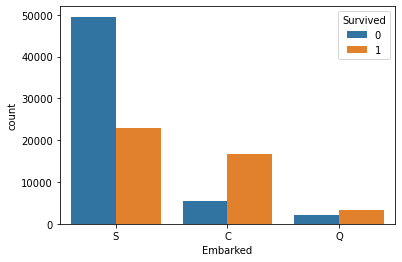

In [334]:
sns.countplot(x='Embarked', hue='Survived', data=titanic_data)

Мы видим, что большинство пассажиров, отправлявшихся их пункта Southampton погибли, для других пунктов отправления доля выживших больше доли погибших.

## Продолжение двумерного анализа

Уже рассмотрены связи всех признаков с целевым, теперь время рассмотреть связи признаков между собой. Построим для этого матрицу корреляции.

In [341]:
#замена категориальных признаков численными
titanic_data.columns
titanic_data['Sex'].replace({'female': 0, 'male': 1}, inplace=True)
titanic_data.loc[titanic_data['Deck'] == 'T', 'Deck'] = np.nan
titanic_data['Deck'].replace({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}, inplace=True)
titanic_data['Embarked'].replace({'S': 1, 'Q': 2, 'C': 3}, inplace=True)
titanic_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Board,FemMem,FareCategory,has_cabin
PassengerId,,,,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",1,44.774464,2,0,209245,27.14,C12239,1,3.0,True,2,9,True
1,0,3,"Bryan, Drew",1,33.407362,0,0,27323,13.35,NaN,1,NaN,NaN,0,6,False
2,0,3,"Owens, Kenneth",1,0.330000,1,2,CA 457703,71.29,NaN,1,NaN,NaN,3,13,False
3,0,3,"Kramer, James",1,19.000000,0,0,A. 10866,13.04,NaN,1,NaN,NaN,0,6,False
4,1,3,"Bond, Michael",1,25.000000,0,0,427635,7.76,NaN,1,NaN,NaN,0,2,False


<AxesSubplot:>

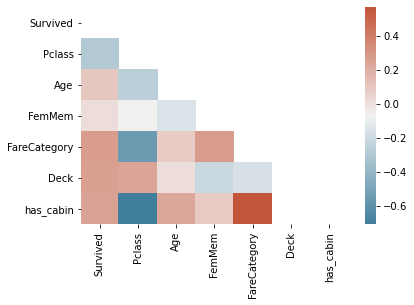

In [381]:
needed_columns = ['Survived','Pclass', 'Sex', 'Age', 'FemMem', 'Embarked', 'FareCategory', 'Deck', 'has_cabin']
titanic_corr = titanic_data[needed_columns].corr()
mask = np.triu(np.ones_like(titanic_corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(titanic_corr, mask=mask, cmap=cmap)

## Связь Pclass с остальными признаками

### Pclass - Sex

<AxesSubplot:xlabel='Pclass', ylabel='count'>

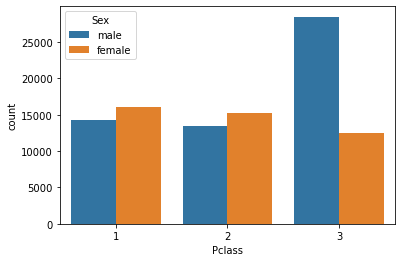

In [346]:
titanic_data['Sex'].replace({0: 'female', 1: 'male'}, inplace=True)
sns.countplot(x='Pclass', hue='Sex', data=titanic_data)

Мы видим, что в третьем классе мужчин было намного больше. В двух других классах мужчин и женщин примерно поровну с небольшим перевесом у женщин.

Рассмотрим Выживаемость женщин и мужчин отдельно в зависимости от класса.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

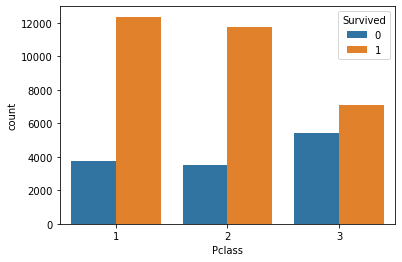

In [347]:
sns.countplot(x='Pclass', hue='Survived', data=titanic_data[titanic_data['Sex'] == 'female'])

Выжила большая часть женщин из первого и второго классов и больше половины женщин из третьего класса. Из этого графика видно, что при спасении приоритет отдавался женщинам, особенно, женщинам более высокого статуса.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

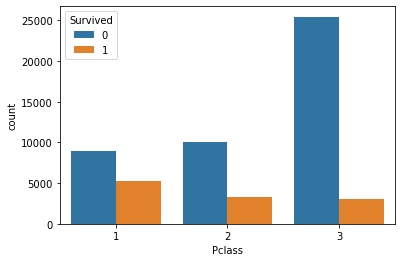

In [348]:
sns.countplot(x='Pclass', hue='Survived', data=titanic_data[titanic_data['Sex'] == 'male'])

Здесь картина обратная: погибло подавляющее большинство мужчин из третьего класса, больше половины из второго. Наибольшая доля выживших мужчин в первом классе.

In [352]:
pd.crosstab([titanic_data['Sex'],titanic_data['Survived']],titanic_data['Pclass'],margins=True).style.background_gradient()

Данная сводная таблица еще раз подтверждает, что больше всего выживших - среди женщин первого и второго классов, больше всего погибших - среди мужчин третьего класса.

### Pclass - Age

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

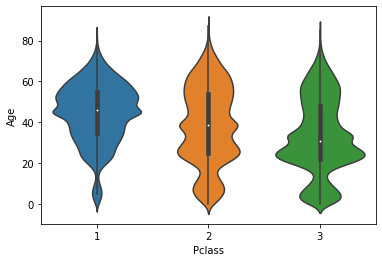

In [354]:
sns.violinplot(x='Pclass', y='Age', data = titanic_data)

Мы видим, что большинство молодых людей и детей относятся к третьему классу, доля людей возрастом 50 лет и старше больше в первом и втором классах.

Рассмотрим выживаемость людей разных возрастов в зависимости от класса.

<AxesSubplot:xlabel='Age', ylabel='Count'>

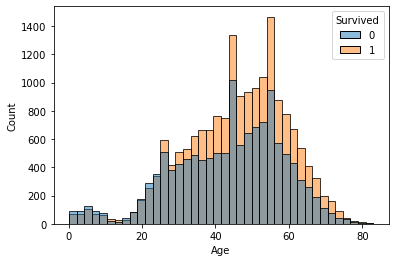

In [356]:
sns.histplot(x='Age', hue='Survived', bins = 40, data=titanic_data[titanic_data['Pclass'] == 1])

<AxesSubplot:xlabel='Age', ylabel='Count'>

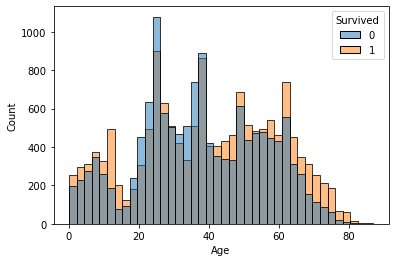

In [357]:
sns.histplot(x='Age', hue='Survived', bins = 40, data=titanic_data[titanic_data['Pclass'] == 2])

<AxesSubplot:xlabel='Age', ylabel='Count'>

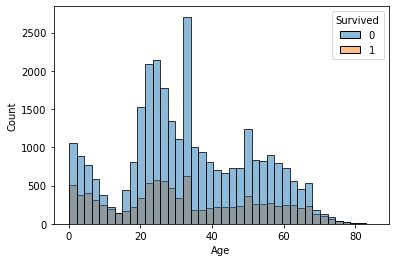

In [358]:
sns.histplot(x='Age', hue='Survived', bins = 40, data=titanic_data[titanic_data['Pclass'] == 3])

Первый класс: примерно до 25 лет выживших и погибших пассажиров примерно поровну. После отметки 25-30 лет больше людей выживали, нежели погибали.
Второй класс: доля выживших больше среди детей (до 20 лет) и взрослых (от 40 до 80 лет), среди молодых пассажиров (20-40 лет) больше погибли, чем выжили.
Третий класс: среди абсолютно всех возрастов больше погибших, чем выживших

### Pclass - FemMem - слабая корреляция

### Pclass - Embarked

<AxesSubplot:xlabel='Embarked', ylabel='count'>

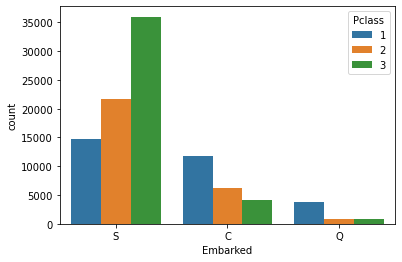

In [372]:
titanic_data['Embarked'].replace({1: 'Southampton', 2:'Queenstown', 3: 'Cherbourg'}, inplace=True)
sns.countplot(x='Embarked', hue='Pclass', data=titanic_data)

Больше всего пассажиров третьего класса сели в Southampton, в Queenstown и Cherbourg больше всего садилось пассажиров первого класса.
Это наблюдение соотносится со связью Embarked - Survived. Больше всего погибших сели именно в Southampton, потому что они относились к третьему классу, а среди севших в Queenstown и Cherbourg больше выжило, потому что среди этих пассажиров больше представителей первого и второго классов.

### Pclass - FareCategory

<AxesSubplot:xlabel='FareCategory', ylabel='count'>

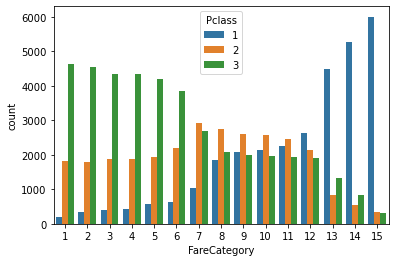

In [373]:
sns.countplot(x='FareCategory', hue='Pclass', data=titanic_data)

Первый класс: большинство билетов от 8-го квантиля и выше, большая часть билетов 13-15 квантиля принадлежит именно первому классу.
Второй класс: довольно равномерное распределение цен на билеты до 12-го квантиля, далее доля дорогих билетов уменьшается.
Третий класс: большая часть билетов до 7-го квантиля, после доля более дорогих билетов уменьшается.

In [375]:
for quantile in range(15):
    print("{} квантиль - {}".format(quantile, titanic_data['Fare'].quantile(quantile/15)))

0 квантиль - 0.68
1 квантиль - 7.05
2 квантиль - 8.3
3 квантиль - 9.31
4 квантиль - 10.29
5 квантиль - 11.43
6 квантиль - 13.51
7 квантиль - 22.81
8 квантиль - 25.7
9 квантиль - 27.84
10 квантиль - 29.889999999999855
11 квантиль - 32.54
12 квантиль - 60.19
13 квантиль - 78.13
14 квантиль - 144.44399999999993


### Pclass - has_cabin

<AxesSubplot:xlabel='has_cabin', ylabel='count'>

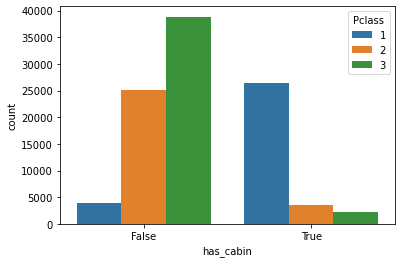

In [377]:
sns.countplot(x='has_cabin', hue='Pclass', data=titanic_data)

Основная часть данных, содержащая номер каюты, - пассажиры первого класса.

# Summary

Был провевен EDA датасета по Титанику.

Выявлены основные признаки, по которым можно определить, выживет пассажир или нет. Это Pclass, Sex и Age, где признак Pclass тесно связан со многими остальными признаками, такими как Fare (и FareCategory, соответственно), has_cabin и Deck, Embarked.